## Step 1 :-  Loading necessary libraries for Analysis 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score,accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, CuDNNLSTM
from keras.layers import Dropout
from keras.optimizers import *
from keras.callbacks import *

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8752441269907537127
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3141979340
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5921701040519084389
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


## Step 2 :- Data load 
<div class="alert alert-block alert-success">
<b>We will be using the NIFTY50 stock price data from Jan 1, 2009 to November 24, 2019</b> 
    <br>
The folder contains files downloaded from https://www1.nseindia.com/products/content/equities/indices/historical_index_data.htm . There are 10 excel files that will be merged together to form one dataset
</div>

In [2]:
path                = r'D:\tcs projects\nifty50'
relevant_data_files = os.listdir(path)
for i in range(len(relevant_data_files)):
    filepath = path+'\\'+relevant_data_files[i]
    if i ==0:
        df          = pd.read_csv(filepath)
    else:
        df1         = pd.read_csv(path+'\\'+relevant_data_files[i])
        df          = df.append(df1)
print('The number of data points in the dataframe :- ',len(df))
print('The top few columns of the dataset will look like :- ')
df.head(5)

The number of data points in the dataframe :-  2695
The top few columns of the dataset will look like :- 


,Date,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr)
0,01-Jan-2009,2963.30,3039.25,2963.30,3033.45,226681072,4302.54
1,02-Jan-2009,3034.60,3079.85,3021.80,3046.75,318672508,6132.72
2,05-Jan-2009,3058.75,3131.95,3056.45,3121.45,311929372,6737.94
3,06-Jan-2009,3121.50,3141.80,3056.10,3112.80,340452916,8091.74
4,07-Jan-2009,3112.80,3147.20,2888.20,2920.40,686898999,10865.55


## Step 3 :- Extracting Features from the data
<div class="alert alert-block alert-success">
<b>Extracting the Closing price of the stock </b> 
    <br>
We are going to work with the closing price of the stock and hence we are going to extract the 'Close' column of the dataframe loaded. The dataset is already sorted and hence we don't need to perform any ordering on the dataset
</div>

In [4]:
sub_data_needed      = df.iloc[:,4:5]
print('The length of the sub data(containing only the volatility of stock prices) we have is:- ', len(sub_data_needed))
sub_data_needed.head(3)

The length of the sub data(containing only the volatility of stock prices) we have is:-  2695


,Close
0,3033.45
1,3046.75
2,3121.45


## Step 4:- Separating the Train and Validation data
<div class="alert alert-block alert-success">
We are going to use the first 2500 dataset values for training the RNN model and the remaining 519 values to check the validity of the model.
</div>

In [5]:
training_set = sub_data_needed.iloc[:2500,:].values
print('The size of training set is:- ',len(training_set))

The size of training set is:-  2500


## Step 5:- Preprocessing Training Data 
<div class="alert alert-block alert-success">
<b>Min-Max Normalization technique </b> 
    <br>
1. We will <b> normalize the training dataset</b> <br>
2.  We will arrange the <b> one dimensional dataset to a two dimensional dataset </b> where each row will consist of 90 timesteps to predict 1 output and we will have a 2 dimensional data having (2500-90) = 2410 rows and 90 columns. <br>
3. We will also store the 91st observation corresponding to every row in a separate array to be used for testing in an LSTM model.<br>
4. The input of the LSTM model is a 3D tensor with shape (batch_size, timesteps, input_dim). <br>
    <b> In our case, batch size is 2410, timesteps is 90 and input_dim = 1 as we are only considering the closing prices </b>
</div>

In [6]:
time_dep            = 90
sc                  = MinMaxScaler()
training_set_scaled = sc.fit_transform(training_set)

X_train             = []
y_train             = []
for i in range(time_dep, 2500):
    X_train.append(training_set_scaled[i-time_dep:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train    = np.array(X_train), np.array(y_train)

X_train             = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print('We get the Training data X of shape :- ',X_train.shape)
print('We get the test data of shape       :- ',y_train.shape)
print('We can clearly see that corresponding to each set of 90 timesteps, we have one value to predict')

We get the Training data X of shape :-  (2410, 90, 1)
We get the test data of shape       :-  (2410,)
We can clearly see that corresponding to each set of 90 timesteps, we have one value to predict


## Step 6 : Callback Creation
We create callbacks which we will be using while execution of the model

In [7]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,verbose=1,
                              patience=5, min_lr=0.0001)
es        = EarlyStopping(monitor='loss', patience=5, verbose=1, mode='auto', baseline=None, 
                          restore_best_weights=True)
filepath   = 'D:\\CHECKPOINTS_LSTM\\'+"weights-improvement-{epoch:02d}-{loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='auto')

## Step 7 : Building the actual model 
<div class="alert alert-block alert-success">
<b>LSTM + Dense layers </b> 
    <br>
1. We will fit an <b> LSTM model having 3 layers</b> <br>
2. We will then get the outcome of the LSTM layers to one dense layer having 100 hidden layers whose outcome will go to one final layer

In [8]:
model = Sequential()
model.add(LSTM(units=456,return_sequences=True,activation='tanh',input_shape = (X_train.shape[1],1)))
model.add(Dropout(0.15))
model.add(LSTM(units=456,return_sequences=True,activation = 'tanh'))
model.add(Dropout(0.2))
model.add(LSTM(units=456))
model.add(Dropout(0.15))

model.add(Dense(units = 388))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = Adam(learning_rate= 2.7e-04), loss = 'mean_squared_error')


W1126 05:04:21.050247 12388 deprecation.py:506] From C:\Users\Batfleck\Anaconda3\envs\keras-gpu\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Step 8 :- Fitting the model
We will fit the model with fixed epochs and batch-size

In [9]:
epochs = 35
batch_sz = 16
history = model.fit(X_train, y_train, 
                      epochs = epochs, 
                      batch_size = batch_sz,
                     callbacks        = [reduce_lr,es,checkpoint])

W1126 05:04:24.556433 12388 module_wrapper.py:139] From C:\Users\Batfleck\Anaconda3\envs\keras-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Epoch 1/35
2410/2410 [==============================] - 41s 17ms/step - loss: 0.0104

Epoch 00001: loss improved from inf to 0.01041, saving model to D:\CHECKPOINTS_LSTM\weights-improvement-01-0.01.hdf5
Epoch 2/35
2410/2410 [==============================] - 41s 17ms/step - loss: 0.0033

Epoch 00002: loss improved from 0.01041 to 0.00332, saving model to D:\CHECKPOINTS_LSTM\weights-improvement-02-0.00.hdf5
Epoch 3/35
2410/2410 [==============================] - 41s 17ms/step - loss: 0.0031

Epoch 00003: loss improved from 0.00332 to 0.00305, saving model to D:\CHECKPOINTS_LSTM\weights-improvement-03-0.00.hdf5
Epoch 4/35
2410/2410 [==============================] - 41s 17ms/step - loss: 0.0023

Epoch 00004: loss improved from 0.00305 to 0.00227, saving model to D:\CHECKPOINTS_LSTM\weights-improvement-04-0.00.hdf5
Epoch 5/35
2410/2410 [==============================] - 41s 17ms/step - loss: 0.0023

Epoch 00005: loss improved from 0.00227 to 0.00226, saving model to D:\CHECKPOINTS_LSTM\we

## Step 9 :- Validating the model
We will now validate the model on a given sequence of stock prices. 
<div class="alert alert-block alert-success">
<b>Validation </b> 
    <br>
1. We will validate the data on the last 519 observations.  <br>
2. We will adjust our data accordingly to get the test data in accordance with the input format needed by the LSTM model that we fitted in step 7 
</div>

In [10]:
dataset_test         = sub_data_needed.iloc[2500:,:]
real_stock_price     = dataset_test.values
inputs = sub_data_needed[len(sub_data_needed)-len(dataset_test)-time_dep:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(time_dep, time_dep+len(dataset_test)):
    X_test.append(inputs[i-time_dep:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## Step 10 :- Performance metrics and Graphical representation

In [11]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
print('The R2 score between the predicted and actual values is: ',round(r2_score(real_stock_price,predicted_stock_price),3))

The R2 score between the predicted and actual values is:  0.938


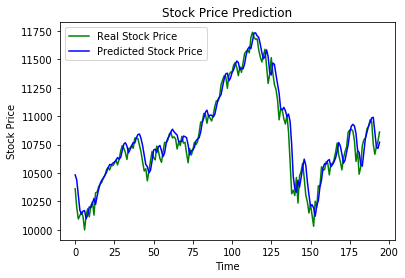

In [12]:
plt.plot(real_stock_price, color = 'green', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


## Step 11: Saving the model for future reference

In [16]:
model.save(r'D:\tcs projects\nifty50modelclosing\lstm_closing.h5')